## IS453 Financial Analytics
## Week 11 - Credit Scoring Lab Data

### Credit risk scorecard construction with scorecardpy

## HMEQ Dataset

The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. 
The data is originally taken from the Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS book website - https://www.bartbaesens.com/book/6/credit-risk-analytics.
A cleaner version of the data is on Kaggle - https://www.kaggle.com/akhil14shukla/loan-defaulter-prediction/data


**Variables definition**

1. BAD: Binary response variable
    - 1 = applicant defaulted on loan or seriously delinquent; 
    - 0 = applicant paid loan or customer is current on loan payments. This is the class column.
2. LOAN: Requested loan amount
3. MORTDUE: Amount due on existing mortgage
4. VALUE: Value of current property
5. REASON: 
    - DebtCon = debt consolidation(customer uses home equity loan to pay back high interest loans)
    - HomeImp = home improvement
6. JOB: Occupational categories
    - ProfExe
    - Mgr
    - Office
    - Self
    - Sales
    - Other
7. YOJ: Years at present job
8. DEROG: Number of major derogatory reports(issued for loans taken in the past when customer fails to keep up the contract or payback on time).
9. DELINQ: Number of delinquent credit lines
10. CLAGE: Age of oldest credit line in months
11. NINQ: Number of recent credit inquiries
12. CLNO: Number of credit lines
13. DEBTINC: Debt-to-income ratio in percent

**Install scorecardpy**
This is a python version of R package scorecard. The API link has more info :

https://pypi.org/project/scorecardpy/

https://github.com/shichenxie/scorecardpy/

https://cran.r-project.org/web/packages/scorecard/scorecard.pdf

In [1]:
# make sure you are running Python 3.9 or later

# depending on your environment, either pip install or conda install the following packages
# !pip install pandas==2.1.1
# !pip install scorecardpy==0.1.9.7

# after downloading, restart your kernel

In [2]:
# ignore scorecardpy compatability warnings
import warnings

import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint

**Read in the original hmeq_data.csv file**

It will have missing values, but that is alright.

In [3]:
# sample code
hmeq_data = pd.read_csv('hmeq_data.csv')

# use a copy of hmeq_data for credit risk model
hmeq_data_forsc = hmeq_data.copy()

# check for missing values
hmeq_data_forsc.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

Drop MORTDUE, is highly correlated with VALUE


In [4]:
# sample code

hmeq_data_forsc.drop(columns='MORTDUE', inplace=True)
hmeq_data_forsc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   VALUE    5848 non-null   float64
 3   REASON   5708 non-null   object 
 4   JOB      5681 non-null   object 
 5   YOJ      5445 non-null   float64
 6   DEROG    5252 non-null   float64
 7   DELINQ   5380 non-null   float64
 8   CLAGE    5652 non-null   float64
 9   NINQ     5450 non-null   float64
 10  CLNO     5738 non-null   float64
 11  DEBTINC  4693 non-null   float64
dtypes: float64(8), int64(2), object(2)
memory usage: 558.9+ KB


**Do train-test split**

`sc.split_df` returns a dictionary of train and test dataset. It uses a fixed random seed.

In [5]:
# sample code

# split data into 70% train and 30% test
train, test = sc.split_df(hmeq_data_forsc, y = 'BAD', ratio = .7).values()
print(train.shape)
print(test.shape)

(4172, 12)
(1788, 12)


**Generate WOE bins**

`sc.webin()` generates groupings as a python dictionary object and also provides a method to plot WOE for the bins.  It will optimize for IV, but will not attempt to make the trend monotonic.

Scorecardpy will automatically do the one-hot encoding as part of the binning process so it is not neccesary to do that in advance.

It will also create missing bins for all the variables, so there is no need to imput or remove missing values.

*Ignore any Python warning messages.*

In [19]:
# automatically calculate bin ranges, bins is a dictionary
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y = 'BAD')

for variables, bindetails in bins.items():
    print(variables, " : ")
    display(bindetails)
    print(bindetails['total_iv'])
    print("--"*50)

[INFO] creating woe binning ...


/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of

REASON  : 


/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/Users/riannelim/anaconda3/lib/python3.11/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future vers

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REASON,missing,168,0.040268,136,32,0.190476,-0.057025,0.000129,0.014904,missing,True
1,REASON,DebtCon,2730,0.654362,2222,508,0.186081,-0.085788,0.004692,0.014904,DebtCon,False
2,REASON,HomeImp,1274,0.305369,982,292,0.229199,0.177056,0.010083,0.014904,HomeImp,False


0    0.014904
1    0.014904
2    0.014904
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
CLNO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CLNO,missing,145,0.034756,111,34,0.234483,0.206724,0.001578,0.084517,missing,True
1,CLNO,"[-inf,10.0)",416,0.099712,280,136,0.326923,0.667759,0.053173,0.084517,10.0,False
2,CLNO,"[10.0,24.0)",2152,0.515820,1762,390,0.181227,-0.118164,0.006947,0.084517,24.0,False
3,CLNO,"[24.0,33.0)",951,0.227948,800,151,0.158780,-0.277438,0.016100,0.084517,33.0,False
4,CLNO,"[33.0,inf)",508,0.121764,387,121,0.238189,0.227259,0.006719,0.084517,inf,False


0    0.084517
1    0.084517
2    0.084517
3    0.084517
4    0.084517
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
LOAN  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LOAN,"[-inf,6000.0)",219,0.052493,113,106,0.484018,1.325945,0.124071,0.167658,6000.0,False
1,LOAN,"[6000.0,17000.0)",1963,0.470518,1559,404,0.205807,0.039509,0.000743,0.167658,17000.0,False
2,LOAN,"[17000.0,38000.0)",1748,0.418984,1482,266,0.152174,-0.327758,0.040642,0.167658,38000.0,False
3,LOAN,"[38000.0,inf)",242,0.058006,186,56,0.231405,0.189499,0.002202,0.167658,inf,False


0    0.167658
1    0.167658
2    0.167658
3    0.167658
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
DEBTINC  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBTINC,missing,866,0.207574,326,540,0.623557,1.894565,1.044727,1.863035,missing,True
1,DEBTINC,"[-inf,40.0)",2674,0.640940,2510,164,0.061331,-1.338278,0.741917,1.863035,40.0,False
2,DEBTINC,"[40.0,42.0)",367,0.087967,328,39,0.106267,-0.739558,0.037960,1.863035,42.0,False
3,DEBTINC,"[42.0,inf)",265,0.063519,176,89,0.335849,0.708046,0.038430,1.863035,inf,False


0    1.863035
1    1.863035
2    1.863035
3    1.863035
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
VALUE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,VALUE,missing,78,0.018696,3,75,0.961538,4.608769,0.411314,0.565594,missing,True
1,VALUE,"[-inf,40000.0)",231,0.055369,149,82,0.354978,0.792667,0.042762,0.565594,40000.0,False
2,VALUE,"[40000.0,50000.0)",217,0.052013,155,62,0.285714,0.473603,0.013314,0.565594,50000.0,False
3,VALUE,"[50000.0,90000.0)",1649,0.395254,1346,303,0.183748,-0.101266,0.003930,0.565594,90000.0,False
4,VALUE,"[90000.0,125000.0)",1086,0.260307,944,142,0.130755,-0.504405,0.056474,0.565594,125000.0,False
5,VALUE,"[125000.0,170000.0)",464,0.111218,362,102,0.219828,0.123222,0.001751,0.565594,170000.0,False
6,VALUE,"[170000.0,200000.0)",212,0.050815,194,18,0.084906,-0.987593,0.035997,0.565594,200000.0,False
7,VALUE,"[200000.0,inf)",235,0.056328,187,48,0.204255,0.029986,0.000051,0.565594,inf,False


0    0.565594
1    0.565594
2    0.565594
3    0.565594
4    0.565594
5    0.565594
6    0.565594
7    0.565594
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
YOJ  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YOJ,missing,364,0.087248,312,52,0.142857,-0.401866,0.012423,0.057791,missing,True
1,YOJ,"[-inf,5.0)",1313,0.314717,997,316,0.240670,0.240885,0.019585,0.057791,5.0,False
2,YOJ,"[5.0,6.0)",246,0.058965,196,50,0.203252,0.023802,0.000034,0.057791,6.0,False
3,YOJ,"[6.0,10.0)",772,0.185043,643,129,0.167098,-0.216439,0.008109,0.057791,10.0,False
4,YOJ,"[10.0,21.0)",1086,0.260307,855,231,0.212707,0.081210,0.001759,0.057791,21.0,False
5,YOJ,"[21.0,inf)",391,0.093720,337,54,0.138107,-0.441205,0.015881,0.057791,inf,False


0    0.057791
1    0.057791
2    0.057791
3    0.057791
4    0.057791
5    0.057791
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
DEROG  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEROG,missing,482,0.115532,422,60,0.124481,-0.560767,0.030411,0.379931,missing,True
1,DEROG,"[-inf,1.0)",3163,0.758150,2642,521,0.164717,-0.233648,0.038509,0.379931,1.0,False
2,DEROG,"[1.0,2.0)",313,0.075024,188,125,0.399361,0.981765,0.092240,0.379931,2.0,False
3,DEROG,"[2.0,inf)",214,0.051294,88,126,0.588785,1.748839,0.218771,0.379931,inf,False


0    0.379931
1    0.379931
2    0.379931
3    0.379931
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
DELINQ  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DELINQ,missing,409,0.098035,356,53,0.129584,-0.514745,0.022075,0.60362,missing,True
1,DELINQ,"[-inf,1.0)",2944,0.705657,2539,405,0.137568,-0.445745,0.121867,0.60362,1.0,False
2,DELINQ,"[1.0,2.0)",444,0.106424,292,152,0.342342,0.737020,0.070214,0.60362,2.0,False
3,DELINQ,"[2.0,inf)",375,0.089885,153,222,0.592000,1.762133,0.389464,0.60362,inf,False


0    0.60362
1    0.60362
2    0.60362
3    0.60362
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
CLAGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CLAGE,missing,209,0.050096,155,54,0.258373,0.335453,0.006205,0.213844,missing,True
1,CLAGE,"[-inf,70.0)",220,0.052733,136,84,0.381818,0.908056,0.054704,0.213844,70.0,False
2,CLAGE,"[70.0,170.0)",1708,0.409396,1291,417,0.244145,0.259807,0.029793,0.213844,170.0,False
3,CLAGE,"[170.0,240.0)",1168,0.279962,979,189,0.161815,-0.254891,0.016810,0.213844,240.0,False
4,CLAGE,"[240.0,280.0)",374,0.089645,343,31,0.082888,-1.013850,0.066341,0.213844,280.0,False
5,CLAGE,"[280.0,inf)",493,0.118169,436,57,0.115619,-0.644697,0.039990,0.213844,inf,False


0    0.213844
1    0.213844
2    0.213844
3    0.213844
4    0.213844
5    0.213844
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
JOB  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,JOB,missing,191,0.045781,176,15,0.078534,-1.072540,0.037180,0.124782,missing,True
1,JOB,Office,663,0.158917,572,91,0.137255,-0.448386,0.027747,0.124782,Office,False
2,JOB,ProfExe,880,0.210930,740,140,0.159091,-0.275114,0.014660,0.124782,ProfExe,False
3,JOB,"Mgr%,%Other",2218,0.531640,1701,517,0.233093,0.198965,0.022307,0.124782,"Mgr%,%Other",False
4,JOB,"Sales%,%Self",220,0.052733,151,69,0.313636,0.606720,0.022887,0.124782,"Sales%,%Self",False


0    0.124782
1    0.124782
2    0.124782
3    0.124782
4    0.124782
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------
NINQ  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NINQ,missing,350,0.083893,297,53,0.151429,-0.333547,0.008412,0.158557,missing,True
1,NINQ,"[-inf,1.0)",1767,0.423538,1489,278,0.157329,-0.288345,0.032201,0.158557,1.0,False
2,NINQ,"[1.0,2.0)",937,0.224593,756,181,0.193170,-0.039651,0.000349,0.158557,2.0,False
3,NINQ,"[2.0,4.0)",832,0.199425,634,198,0.237981,0.226112,0.010890,0.158557,4.0,False
4,NINQ,"[4.0,inf)",286,0.068552,164,122,0.426573,1.094048,0.106706,0.158557,inf,False


0    0.158557
1    0.158557
2    0.158557
3    0.158557
4    0.158557
Name: total_iv, dtype: float64
----------------------------------------------------------------------------------------------------


### Logistic regression with WOE encoding

Use `sc.woebin_ply` to encode the WOE values

Generate the logistic regression model based on the encoded WOE values

In [7]:
# sample code

# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_woe = sc.woebin_ply(train, bins)
    test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,BAD,REASON_woe,CLNO_woe,LOAN_woe,DEBTINC_woe,VALUE_woe,YOJ_woe,DEROG_woe,DELINQ_woe,CLAGE_woe,JOB_woe,NINQ_woe
0,1,0.177056,0.667759,1.325945,1.894565,0.792667,0.081210,-0.233648,-0.445745,0.259807,0.198965,-0.039651
1,1,0.177056,-0.118164,1.325945,1.894565,-0.101266,-0.216439,-0.233648,1.762133,0.259807,0.198965,-0.288345
3,1,-0.057025,0.206724,1.325945,1.894565,4.608769,-0.401866,-0.560767,-0.514745,0.335453,-1.072540,-0.333547
4,0,0.177056,-0.118164,1.325945,1.894565,-0.504405,0.240885,-0.233648,-0.445745,0.259807,-0.448386,-0.288345
5,1,0.177056,0.667759,1.325945,-1.338278,0.473603,-0.216439,-0.233648,-0.445745,0.259807,0.198965,-0.039651
...,...,...,...,...,...,...,...,...,...,...,...,...
5951,0,-0.085788,-0.118164,0.189499,-1.338278,-0.504405,0.081210,-0.233648,-0.445745,-0.254891,0.198965,-0.288345
5952,0,-0.085788,-0.118164,0.189499,-1.338278,-0.504405,0.081210,-0.233648,-0.445745,-0.254891,0.198965,-0.288345
5955,0,-0.085788,-0.118164,0.189499,-1.338278,-0.504405,0.081210,-0.233648,-0.445745,-0.254891,0.198965,-0.288345
5957,0,-0.085788,-0.118164,0.189499,-1.338278,-0.504405,0.081210,-0.233648,-0.445745,-0.254891,0.198965,-0.288345


In [8]:
# sample code

# create the X, y parts of data for train and test
y_train = train_woe.loc[:, 'BAD']
X_train = train_woe.loc[:, train_woe.columns != 'BAD']
y_test = test_woe.loc[:, 'BAD']
X_test = test_woe.loc[:, train_woe.columns != 'BAD']

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

intercept      0.017365
REASON_woe     0.058415
CLNO_woe       0.958418
LOAN_woe       0.460833
DEBTINC_woe    0.952860
VALUE_woe      0.881111
YOJ_woe        1.065722
DEROG_woe      0.692503
DELINQ_woe     0.957246
CLAGE_woe      1.058797
JOB_woe        0.946893
NINQ_woe       0.529574
dtype: float64

### Generate scorecard

Use `sc.scorecard` to generate the scorecard

In [9]:
# sample code

# generate a card from the model and bins. The scores will be based on probability of default from the model
# bins = bins created from sc.woebin
# lr = fitted logistic regression model
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'CLAGE':    variable            bin  points
38    CLAGE        missing    36.0
39    CLAGE    [-inf,70.0)    19.0
40    CLAGE   [70.0,170.0)    39.0
41    CLAGE  [170.0,240.0)    54.0
42    CLAGE  [240.0,280.0)    78.0
43    CLAGE    [280.0,inf)    66.0,
 'CLNO':   variable          bin  points
3     CLNO      missing    41.0
4     CLNO  [-inf,10.0)    28.0
5     CLNO  [10.0,24.0)    50.0
6     CLNO  [24.0,33.0)    54.0
7     CLNO   [33.0,inf)    40.0,
 'DEBTINC':    variable          bin  points
12  DEBTINC      missing    -5.0
13  DEBTINC  [-inf,40.0)    83.0
14  DEBTINC  [40.0,42.0)    67.0
15  DEBTINC   [42.0,inf)    27.0,
 'DELINQ':    variable         bin  points
34   DELINQ     missing    61.0
35   DELINQ  [-inf,1.0)    59.0
36   DELINQ   [1.0,2.0)    26.0
37   DELINQ   [2.0,inf)    -2.0,
 'DEROG':    variable         bin  points
30    DEROG     missing    58.0
31    DEROG  [-inf,1.0)    51.0
32    DEROG   [1.0,2.0)    27.0
33    DEROG   [2.0,inf)    12.0,
 'JOB':    variable  

**Ex Q1. Calculate the approval status for a new application**

Manually calcuate the score and approval status for a cutoff score of 600 and an application with the following information:<BR>
- LOAN = 88,900
- VALUE = 57,264
- REASON = DebtCon
- JOB = Other
- YOJ = 16.0
- DEROG = 0
- DELINQ = 0
- CLAGE = 221.8
- NINQ = 0
- CLNO = 16
- DEBTINC = 36.1

Your answer here

it got rejected - since the total score is 573 which is lower than the cutoff

Use `sc.scorecard_ply` to score a new application with the same values

In [10]:
# sample code

# calulate credit score for new application
col = ['LOAN','VALUE','REASON','JOB','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']
val = [[88900,57264,'DebtCon','Other',16.0,0.0,0.0,221.8,0.0,16.0,36.1]]
new_appl = pd.DataFrame(val, columns = col)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score = False).transpose()
new_appl_score.index = new_appl_score.index.str.replace('_points', '')

summary = pd.concat([new_appl.transpose(), new_appl_score], axis=1)
summary.columns = ['App Value', 'Points']
print(summary)

        App Value  Points
LOAN        88900    44.0
VALUE       57264    49.0
REASON    DebtCon    47.0
JOB         Other    41.0
YOJ          16.0    44.0
DEROG         0.0    51.0
DELINQ        0.0    59.0
CLAGE       221.8    54.0
NINQ          0.0    51.0
CLNO         16.0    50.0
DEBTINC      36.1    83.0
score         NaN   573.0


### Score all the test and train data

Use `sc.scorecard_ply` to score all the test and train data

In [11]:
# sample code

# credit score for samples in test and train
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_score = sc.scorecard_ply(train, card)
    test_score = sc.scorecard_ply(test, card)

### Evaluate the model's performance

**Calculate Percentage Correctly Classified measures on the scorecard model**


In [12]:
# sample code

# check model performance at 20:1 odds of default
cutoff=560

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[1950 1390]
 [  31  801]]
PCC measures:
              precision    recall  f1-score   support

           0       0.98      0.58      0.73      3340
           1       0.37      0.96      0.53       832

    accuracy                           0.66      4172
   macro avg       0.67      0.77      0.63      4172
weighted avg       0.86      0.66      0.69      4172

*** Test Data Performance ***
Confusion matrix:
[[867 564]
 [ 14 343]]
PCC measures:
              precision    recall  f1-score   support

           0       0.98      0.61      0.75      1431
           1       0.38      0.96      0.54       357

    accuracy                           0.68      1788
   macro avg       0.68      0.78      0.65      1788
weighted avg       0.86      0.68      0.71      1788



**Ex Q2. Compare the train vs test model performance**

- How do the f1-scores for the training and test dataset compare?
- How do the recall and specificity compare?
- Does the model appear to be overfitting the training data? 

Your answer here

- f1 score for training = 0.73, test = 0.75
- recall for training = 0.58, test = 0.61
- specificity for training = 0.66, test = 0.96 

the model does not seem to be overfitting the data f1 score and recall are pretty close

### Evaluate effect of changing the cutoff score

Examine the distribution of the scores

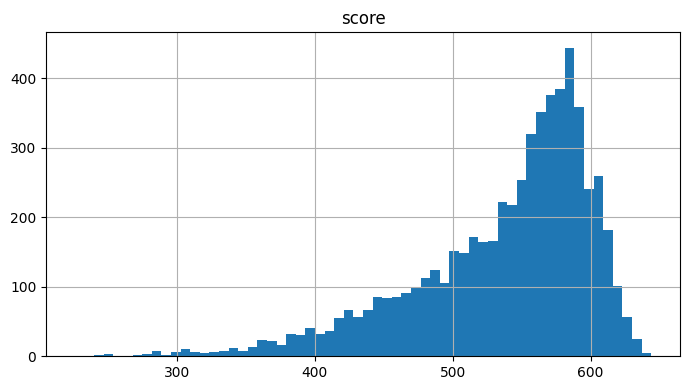

In [13]:
# combine scores for train and test data to assess distribution for entire population
combined_score = pd.concat([train_score, test_score], ignore_index=True)

# plot distribution of scores on copmbined data
combined_score.hist(figsize = (7, 4), bins = 60)
plt.tight_layout()

In [14]:
# sample code
cutoff = 560

approval_count = train_score[train_score["score"]>cutoff].count()['score']
approval_rate = approval_count/train_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

Cutoff score of 560: 1,925 applications approved (46.1%)


In [15]:
# sample code

# calculate expected number of defaults
odds_at_cutoff = 5

default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

Cutoff score of 560: 321 defaults expected


**Ex Q3. Evaluate the effect of adjusting the cutoff score**

Change the cutoff score to 600
- What is the number of applications approved?
- What is the number of defaults expected? 
- How does the recall and specificity performance change?

In [16]:
# your code here
cutoff=600

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[ 517 2823]
 [   6  826]]
PCC measures:
              precision    recall  f1-score   support

           0       0.99      0.15      0.27      3340
           1       0.23      0.99      0.37       832

    accuracy                           0.32      4172
   macro avg       0.61      0.57      0.32      4172
weighted avg       0.84      0.32      0.29      4172

*** Test Data Performance ***
Confusion matrix:
[[ 218 1213]
 [   2  355]]
PCC measures:
              precision    recall  f1-score   support

           0       0.99      0.15      0.26      1431
           1       0.23      0.99      0.37       357

    accuracy                           0.32      1788
   macro avg       0.61      0.57      0.32      1788
weighted avg       0.84      0.32      0.28      1788



In [17]:
cutoff = 600

approval_count = train_score[train_score["score"]>cutoff].count()['score']
approval_rate = approval_count/train_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

Cutoff score of 600: 501 applications approved (12.0%)


In [18]:
# calculate expected number of defaults
odds_at_cutoff = 20

default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

Cutoff score of 600: 24 defaults expected


Your answer here

- number of application approved = 501
- number of defaults expected = 24 (odds at 20) need to change since it's fixed 
- recall decreases and specificity increases

### DIY

**Use scorecardpy for your group assignment**

use autobinning and sort based on IV and take top n (15/20) and do coarse classing and put business hat on